<a href="https://colab.research.google.com/github/vforjj/AI-ML-Review/blob/main/ch35_%5B%EC%8B%A4%EC%8A%B535%5D_%ED%95%B4%EC%99%B8_%EC%8B%A0%EC%9A%A9_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch35.[실습35] 해외 신용 데이터 분석


### 데이터 분석 목적
    - 독일인 개인별 경제 Profile 데이터를 기반으로, 신용 할 수 있는 사람인지 아닌지 여부에 따라 금융 상품 허용 여부를 결정한다
   
### Key Point
    - categorical, numeric 데이터를 모두 분석하는 방법을 배우고, 통계 검정을 통해 Feature Selection 방법을 배운다
    - 모델 최적화 방법중 Random 기반과 Grid 기반 방법을 배운다
    - 모델 분석 결과를 해석하는 2가지 방법을 배운다 (FI, Shapley Value)




In [ ]:
!pip install --upgrade pandas-profiling
# 런타임 재실행 필수!

In [ ]:
!pip install shap

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# library for feature engineering and EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from IPython.display import Image
import pandas_profiling
from datetime import datetime

# library for statistic
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import kruskal
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt


# library for sampling
from imblearn.combine import SMOTEENN

# library for machine learning
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

import shap

%matplotlib inline

<ipython-input-2-567872df67a6>:9: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


## 1. Data Processing 1

### 1-1 Data Load

In [ ]:
!pwd
path_lecture = "./drive/MyDrive/MLSignature/Lecture/Part4/ch35/"
random_state = 1234

/content


In [ ]:
df = pd.read_csv(path_lecture + "data/german_credit_risk_data.csv", sep=";")
df.head()

,Creditability,Account_Balance,Duration_of_Credit_monthly,Payment_Status_of_Previous_Credit,Purpose,Credit_Amount,Value_Savings_Stocks,Length_of_current_employment,Instalment_per_cent,Sex_Marital_Status,...,Duration_in_Current_address,Most_valuable_available_asset,Age_years,Concurrent_Credits,Type_of_apartment,No_of_Credits_at_this_Bank,Occupation,No_of_dependents,Telephone,Foreign_Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2


In [ ]:
df.columns

Index(['Creditability', 'Account_Balance', 'Duration_of_Credit_monthly',
       'Payment_Status_of_Previous_Credit', 'Purpose', 'Credit_Amount',
       'Value_Savings_Stocks', 'Length_of_current_employment',
       'Instalment_per_cent', 'Sex_Marital_Status', 'Guarantors',
       'Duration_in_Current_address', 'Most_valuable_available_asset',
       'Age_years', 'Concurrent_Credits', 'Type_of_apartment',
       'No_of_Credits_at_this_Bank', 'Occupation', 'No_of_dependents',
       'Telephone', 'Foreign_Worker'],
      dtype='object')

### 1-2 Duplicated Data 확인

In [ ]:
print("중복된 항목 수 :", len(df[df.duplicated()]))

중복된 항목 수 : 0


## 2. Data EDA

### 2-1 Data Type and Summary

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Creditability                      1000 non-null   int64
 1   Account_Balance                    1000 non-null   int64
 2   Duration_of_Credit_monthly         1000 non-null   int64
 3   Payment_Status_of_Previous_Credit  1000 non-null   int64
 4   Purpose                            1000 non-null   int64
 5   Credit_Amount                      1000 non-null   int64
 6   Value_Savings_Stocks               1000 non-null   int64
 7   Length_of_current_employment       1000 non-null   int64
 8   Instalment_per_cent                1000 non-null   int64
 9   Sex_Marital_Status                 1000 non-null   int64
 10  Guarantors                         1000 non-null   int64
 11  Duration_in_Current_address        1000 non-null   int64
 12  Most_valuable_availab

In [ ]:
df.columns

Index(['Creditability', 'Account_Balance', 'Duration_of_Credit_monthly',
       'Payment_Status_of_Previous_Credit', 'Purpose', 'Credit_Amount',
       'Value_Savings_Stocks', 'Length_of_current_employment',
       'Instalment_per_cent', 'Sex_Marital_Status', 'Guarantors',
       'Duration_in_Current_address', 'Most_valuable_available_asset',
       'Age_years', 'Concurrent_Credits', 'Type_of_apartment',
       'No_of_Credits_at_this_Bank', 'Occupation', 'No_of_dependents',
       'Telephone', 'Foreign_Worker'],
      dtype='object')

In [ ]:
# categorical and numeric columns
for column_name in list(df.columns):
    print(column_name, df[column_name].dtype, df[column_name].unique())

Creditability int64 [1 0]
Account_Balance int64 [1 2 4 3]
Duration_of_Credit_monthly int64 [18  9 12 10  8  6 24 11 30 48 36 15 42 21 27 33 28  4 47 14 39 60  5 22
 54 13 16  7 20 26 45 72 40]
Payment_Status_of_Previous_Credit int64 [4 2 3 0 1]
Purpose int64 [ 2  0  9  3  1 10  5  4  6  8]
Credit_Amount int64 [ 1049  2799   841  2122  2171  2241  3398  1361  1098  3758  3905  6187
  1957  7582  1936  2647  3939  3213  2337  7228  3676  3124  2384  1424
  4716  4771   652  1154  3556  4796  3017  3535  6614  1376  1721   860
  1495  1934  3378  3868   996  1755  1028  2825  1239  1216  1258  1864
  1474  1382   640  3919  1224  2331  6313   385  1655  1053  3160  3079
  1163  2679  3578 10875  1344  1237  3077  2284  1567  2032  2745  1867
  2299   929  3399  2030  3275  1940  1602  1979  2022  3342  5866  2360
  1520  3651  2346  4454   666  1965  1995  2991  4221  1364  6361  4526
  3573  4455  2136  5954  3777   806  4712  7432  1851  1393  1412  1473
  1533  2012  3959   428  2366  

In [ ]:
# categorical -> object
# unique value와 data description을 함께 확인하며, heuristic 하게 결정.

list_casting_as_object = ["Creditability", "Account_Balance", "Payment_Status_of_Previous_Credit", "Purpose", "Length_of_current_employment", "Sex_Marital_Status", "Guarantors", "Duration_in_Current_address", "Most_valuable_available_asset", "Concurrent_Credits", "Type_of_apartment", "Occupation", "No_of_dependents", "Telephone", "Foreign_Worker"]
for column_name in list_casting_as_object:
  df[column_name] = df[column_name].astype("object")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Creditability                      1000 non-null   object
 1   Account_Balance                    1000 non-null   object
 2   Duration_of_Credit_monthly         1000 non-null   int64 
 3   Payment_Status_of_Previous_Credit  1000 non-null   object
 4   Purpose                            1000 non-null   object
 5   Credit_Amount                      1000 non-null   int64 
 6   Value_Savings_Stocks               1000 non-null   int64 
 7   Length_of_current_employment       1000 non-null   object
 8   Instalment_per_cent                1000 non-null   int64 
 9   Sex_Marital_Status                 1000 non-null   object
 10  Guarantors                         1000 non-null   object
 11  Duration_in_Current_address        1000 non-null   object
 12  Most_va

In [ ]:
list_categorical_columns = list(df.select_dtypes(include=['object']).columns)
list_numeric_columns = list(df.select_dtypes(include=['int64']).columns)
print(len(df.columns))
print(len(list_categorical_columns))
print(len(list_numeric_columns))

21
15
6


In [ ]:
target_column = "Creditability"

#### Summary of Data Set
##### - Number of Variables : 21
    numeric variables : 6
    categorical variables : 15 (target 포함)
##### - Number of observations : 1000
##### - Missing Cells : 0 columns
##### - Duplicated Rows : 0

### 2-2 Dependent(종속) Data Explore

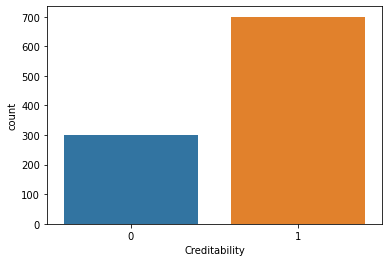

In [ ]:
sns.countplot(x=target_column, data=df)
plt.show()

### 2-3 Independent(독립) Data Explore

#### 1) Categorical Data Analysis

In [ ]:
# 분석전 target column을 categorical list에서 제외
list_categorical_columns.remove(target_column)

##### 불필요한 컬럼 확인

In [ ]:
df[list_categorical_columns].nunique().sort_values()
# 제거할 컬럼 없음

No_of_dependents                      2
Telephone                             2
Foreign_Worker                        2
Guarantors                            3
Concurrent_Credits                    3
Type_of_apartment                     3
Account_Balance                       4
Sex_Marital_Status                    4
Duration_in_Current_address           4
Most_valuable_available_asset         4
Occupation                            4
Payment_Status_of_Previous_Credit     5
Length_of_current_employment          5
Purpose                              10
dtype: int64

##### Column별 분포 확인

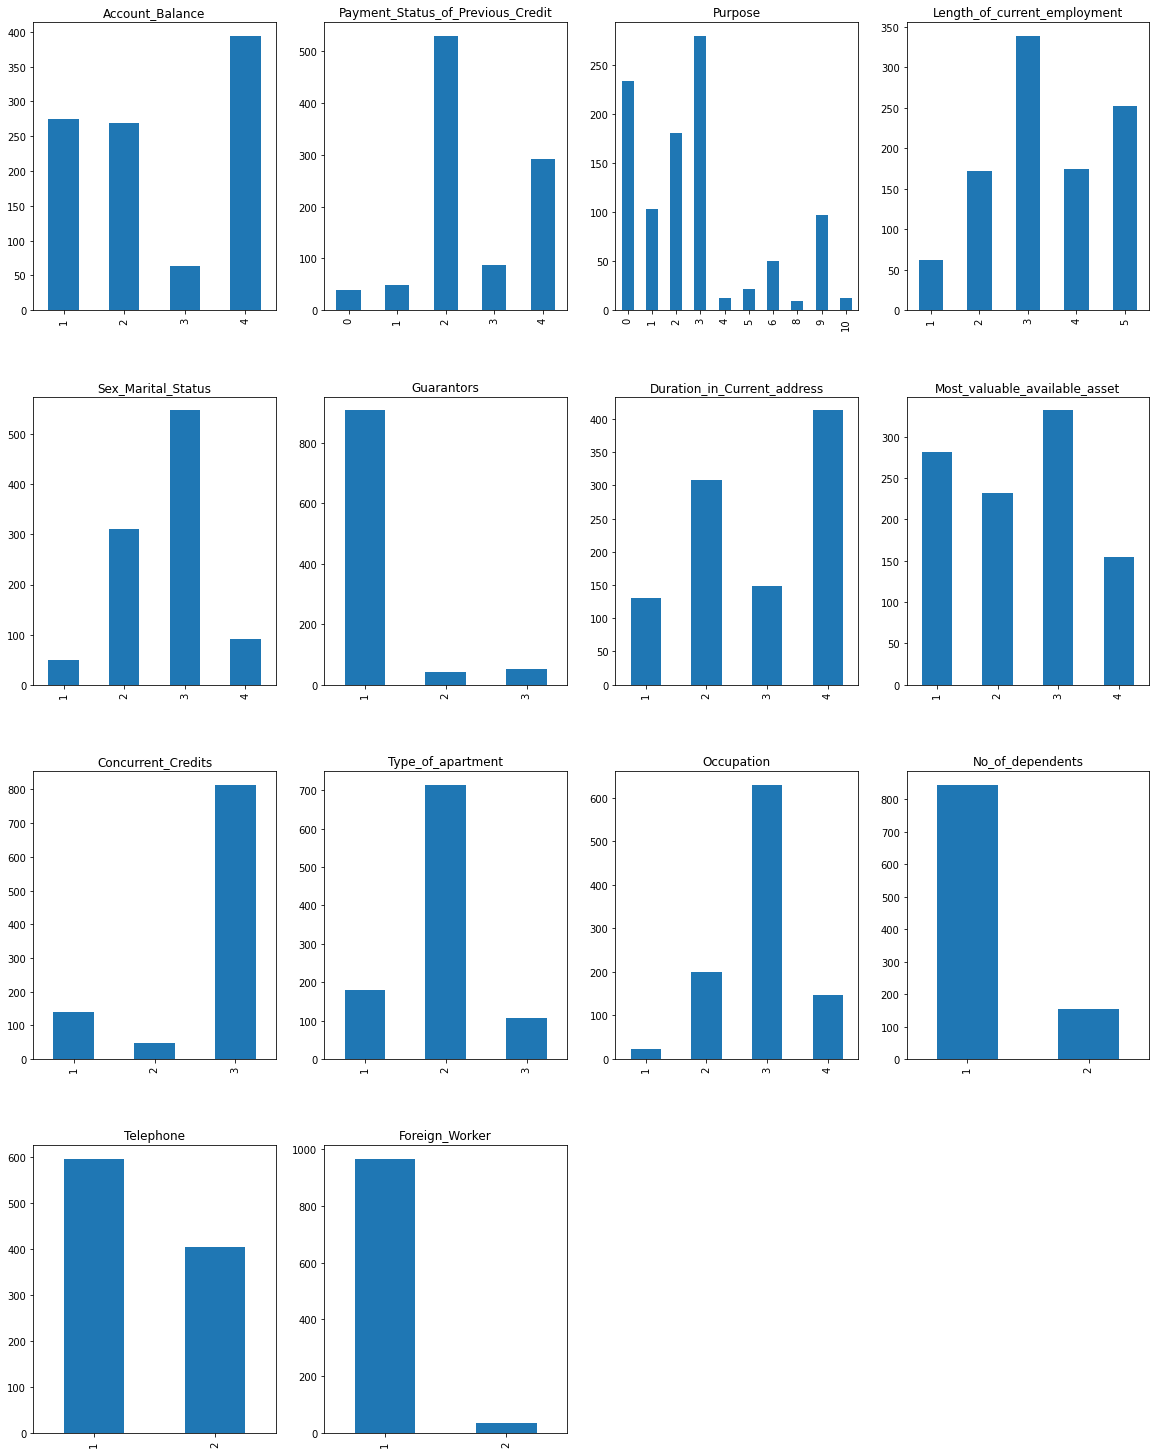

In [ ]:
# cateogircla column 별 분포 확인
plt.figure(figsize=(20,20))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.3, wspace=0.2)
for column_name in list_categorical_columns:
    plt.subplot(4,4,x)
    x = x+1
    df[column_name].value_counts().sort_index().plot(kind='bar')
    plt.title(column_name)
plt.show()

##### Target column과 categorical column 관계 분포 확인

<Figure size 2160x2160 with 0 Axes>

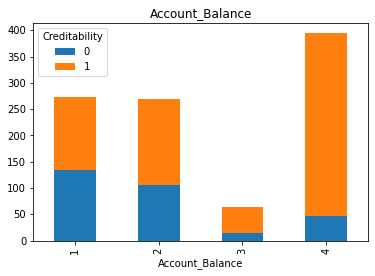

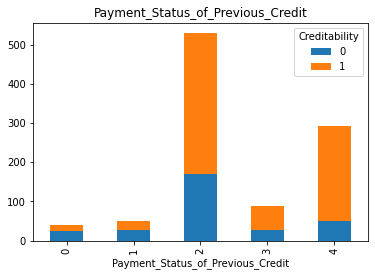

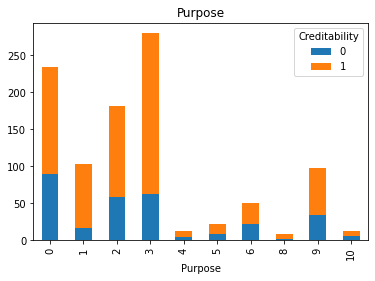

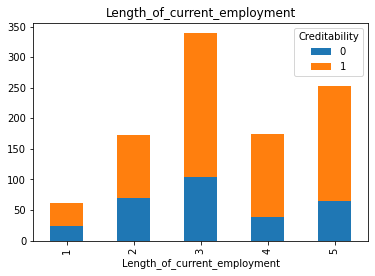

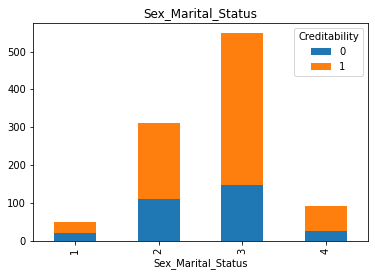

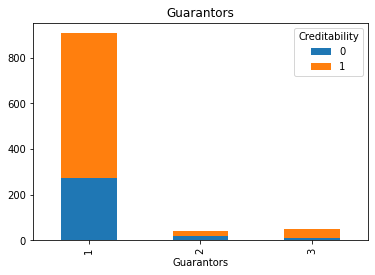

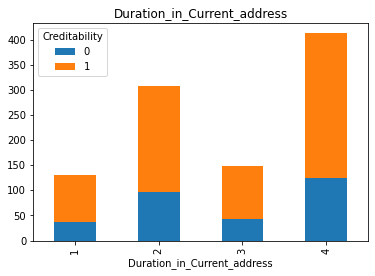

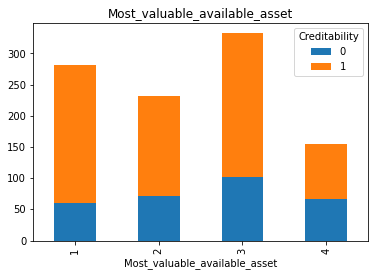

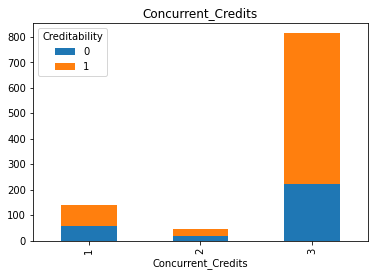

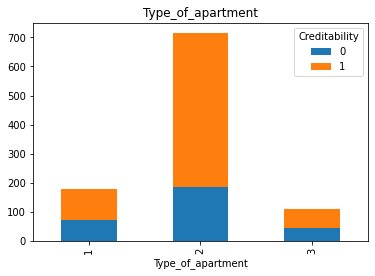

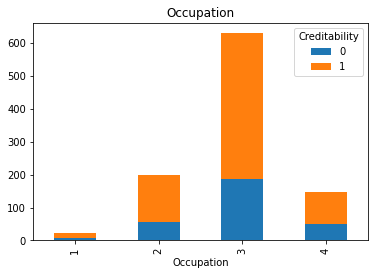

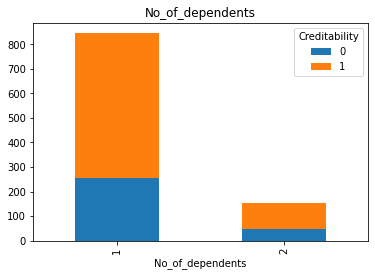

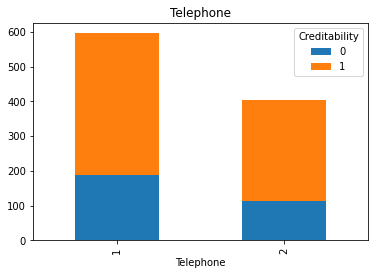

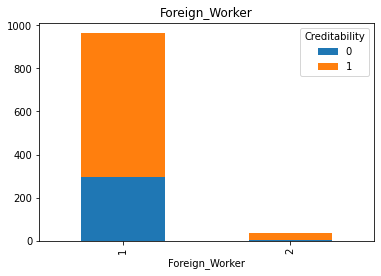

In [ ]:
# categorical column과 dependent data(target column) 분포 분석
plt.figure(figsize=(30,30))
x = 1
#plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.8, wspace=0.2)
for column_name in list_categorical_columns:
    #plt.subplot(4,4,x)
    x = x+1
    df.groupby([column_name, "Creditability"]).count().iloc[:,1].unstack().plot(kind='bar', stacked=True)
    plt.title(column_name)
plt.show()

##### 카이제곱 검정 (chisqaure-test)
*   카이제곱 검정은 두 범주형 변수에 대한 분석 방법.
*   예를 들어, 성별에 따른 선호 영화 장르 비교 문제.
*   본 실습에서는 독립 변수중의 categorical column data와 Creditablity 간의 관계를 검증.
*   pvalue는 0.05 이하인 경우, 귀무가설을 기각한다고 정한다. (pvalue 기준은 항상 다를 수 있음. 정확한 기준은 없으나 일반적으로 0.05 사용)
*   https://ko.wikipedia.org/wiki/카이제곱_검정



In [ ]:
pd.crosstab(df["Creditability"], df["Guarantors"])

Guarantors,1,2,3
Creditability,,,
0,272,18,10
1,635,23,42


In [ ]:
list_meaningful_column_by_chi = []
for column_name in list_categorical_columns:
  statistic, pvalue, _, _ = chi2_contingency(pd.crosstab(df["Creditability"], df[column_name]))
  if pvalue <= 0.05:
    list_meaningful_column_by_chi.append(column_name)
  print(column_name, ", ",statistic,", ", pvalue)
print("all categorical columns : ", len(list_categorical_columns))
print("selected columns by chi : ", len(list_meaningful_column_by_chi), list_meaningful_column_by_chi)

Account_Balance ,  123.7209435162656 ,  1.2189020722893755e-26
Payment_Status_of_Previous_Credit ,  61.69139696459551 ,  1.2791872956750918e-12
Purpose ,  33.35644686141815 ,  0.00011574910079691586
Length_of_current_employment ,  18.3682738466968 ,  0.0010454523491402541
Sex_Marital_Status ,  9.60521395933605 ,  0.02223800546926877
Guarantors ,  6.645366537264244 ,  0.036055954027247206
Duration_in_Current_address ,  0.7492964483880513 ,  0.8615521320413175
Most_valuable_available_asset ,  23.719551283864707 ,  2.8584415733250017e-05
Concurrent_Credits ,  12.839187735866137 ,  0.0016293178186473534
Type_of_apartment ,  18.674005392894895 ,  8.810311250241031e-05
Occupation ,  1.8851560280131707 ,  0.5965815918843431
No_of_dependents ,  0.0 ,  1.0
Telephone ,  1.1725585310208857 ,  0.2788761543035742
Foreign_Worker ,  5.821575915033861 ,  0.015830754902852885
all categorical columns :  14
selected columns by chi :  10 ['Account_Balance', 'Payment_Status_of_Previous_Credit', 'Purpose', 

##### Insight
1.   Creditability(종속 변수)와 유의미한 관계를 갖지 않는 categorical data가 확인됨 (4개가 유의미하지 않음)
2.   feature selection 및 model optimization을 위해 1번에서 얻은 결과를 활용



#### 2) Numeric Data Analysis

##### 불필요한 컬럼 확인

In [ ]:
df[list_numeric_columns].nunique().sort_values()

Instalment_per_cent             4
No_of_Credits_at_this_Bank      4
Value_Savings_Stocks            5
Duration_of_Credit_monthly     33
Age_years                      53
Credit_Amount                 923
dtype: int64

<AxesSubplot:xlabel='Credit_Amount', ylabel='Count'>

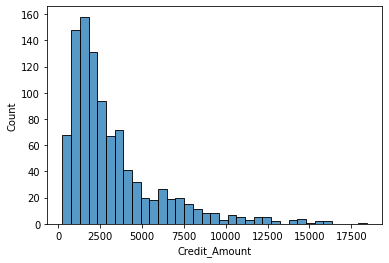

In [ ]:
#Credit_Amount가 데이터 수와 유사한 수준의 unique() 값을 보이므로, histplot으로 한 번 더 확인.
sns.histplot(x="Credit_Amount", data=df)

##### Column별 분포 확인

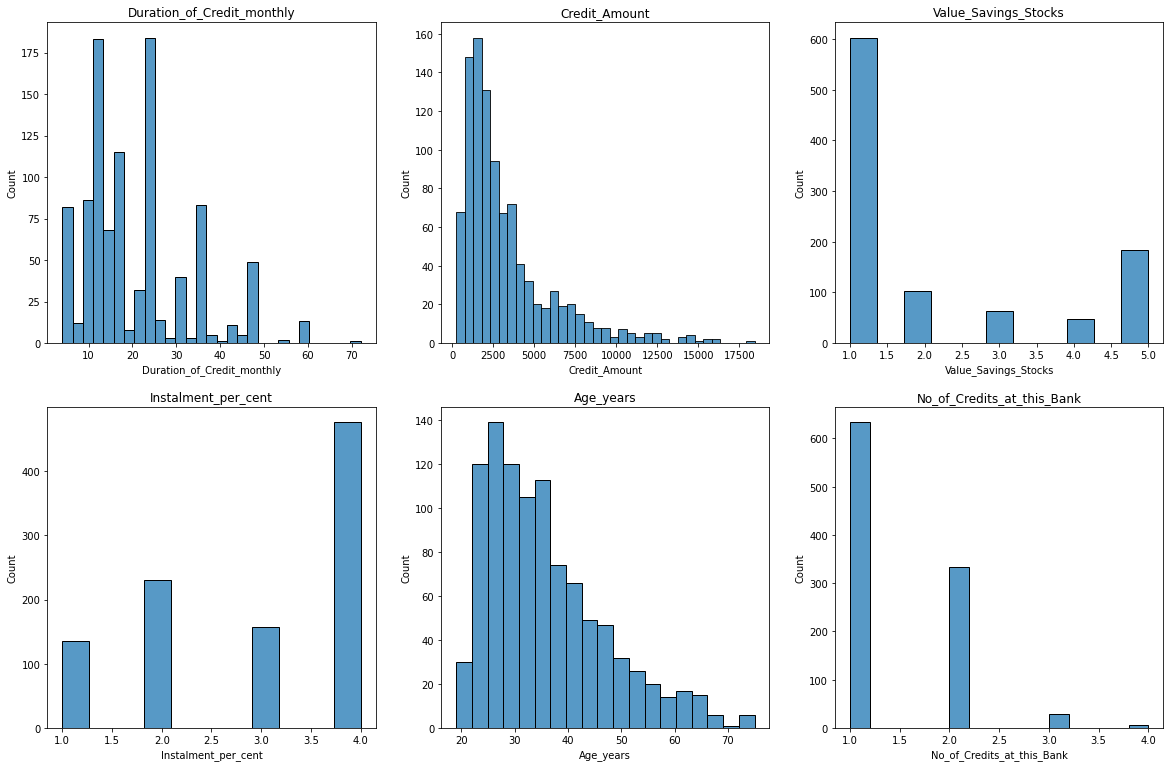

In [ ]:
# numeric column 별 분포 확인
plt.figure(figsize=(20,10))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2, wspace=0.2)
for column_name in list_numeric_columns:
    plt.subplot(2,3,x)
    x = x+1
    sns.histplot(x=column_name, data=df)
    plt.title(column_name)
plt.show()

In [ ]:
for column_name in list_numeric_columns:
  print(column_name, "skew : ", skew(df[column_name]))
  print(column_name, "kur : ", kurtosis(df[column_name]))

# 추후 scaling을 활용한 feature preprocessing의 필요성 확인

Duration_of_Credit_monthly skew :  1.0925422109540106
Duration_of_Credit_monthly kur :  0.9091948811374047
Credit_Amount skew :  1.9466686761323513
Credit_Amount kur :  4.265054224176543
Value_Savings_Stocks skew :  1.0151512255589377
Value_Savings_Stocks kur :  -0.6828220851514768
Instalment_per_cent skew :  -0.5305507598158565
Instalment_per_cent kur :  -1.210423225610213
Age_years skew :  1.023174316054808
Age_years kur :  0.6114371688367677
No_of_Credits_at_this_Bank skew :  1.2706663071344098
No_of_Credits_at_this_Bank kur :  1.5904343926328481


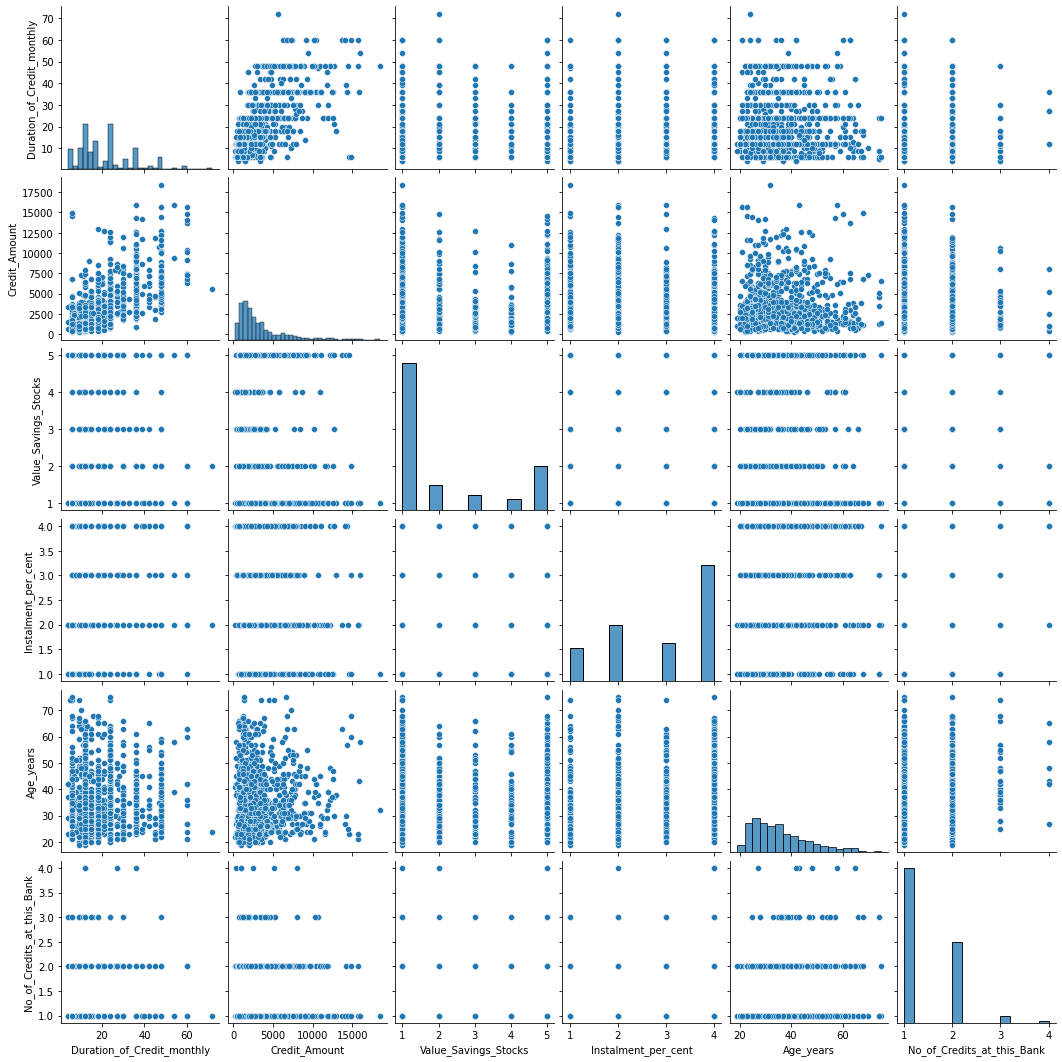

In [ ]:
sns.pairplot(data=df.loc[:, list_numeric_columns])

# 1. 대출 희망 금액이 많아질 수록, 대출 희망 기간도 늘어나는 경향을 보임
# 2. 저축액과 소득대비 상환 납입비율은 상관이 없어 보임
# 3. 해당 은행에 대출이 3개 이상 있는 사람은 대출 희망 기간을 길게 하지 않음

##### Correlation Analysis

<AxesSubplot:>

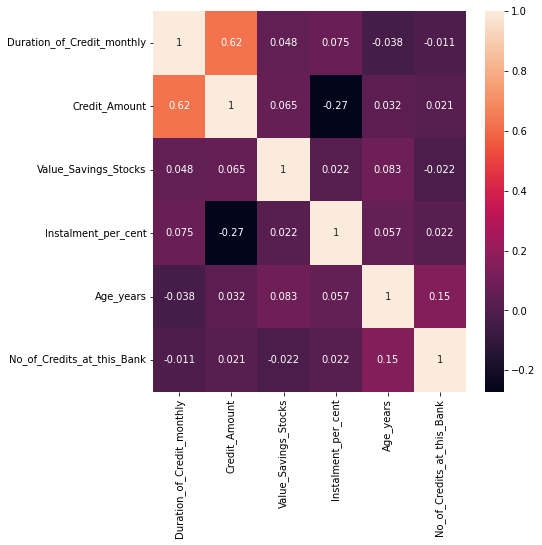

In [ ]:
plt.figure(figsize=(7,7))
sns.heatmap(df[list_numeric_columns].corr(), annot=True)

##### Target Column과 numeric Column 관계 분포 확인

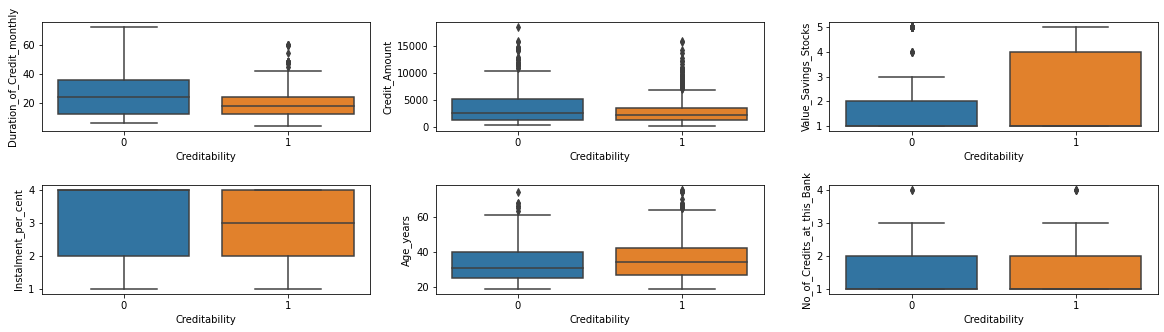

In [ ]:
plt.figure(figsize=(20,20))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.2)
for column_name in list_numeric_columns:
    plt.subplot(9,3,x)
    x = x + 1
    sns.boxplot(data=df,x='Creditability',y=column_name)
plt.show()

##### 일원분산분석 (ANOVA)
*   카테고리별 numeric data 분포 차이를 검증
*   예를 들어, 성별에 따른 키 분포 분석 검증
*   전제 : 정규성, 등분산성, 독립성 (만족하지 않으면 해당 검정을 신뢰할 수 없음)
*   본 실습에서는 target column 에 따른
numerical column 분포 관계를 검증.
*   pvalue는 0.05 이하인 경우, 귀무가설을 기각한다고 정한다. (pvalue 기준은 항상 다를 수 있음. 정확한 기준은 없으나 일반적으로 0.05 사용)
*   https://ko.wikipedia.org/wiki/분산_분석#일원분산분석(one-way_ANOVA)

정규성 검정
*   분산 분석을 위해서는 데이터가 정규성을 만족해야함
*   다양한 방법을 통해서 정규성을 검정 : qqplot, shapiro wilk test

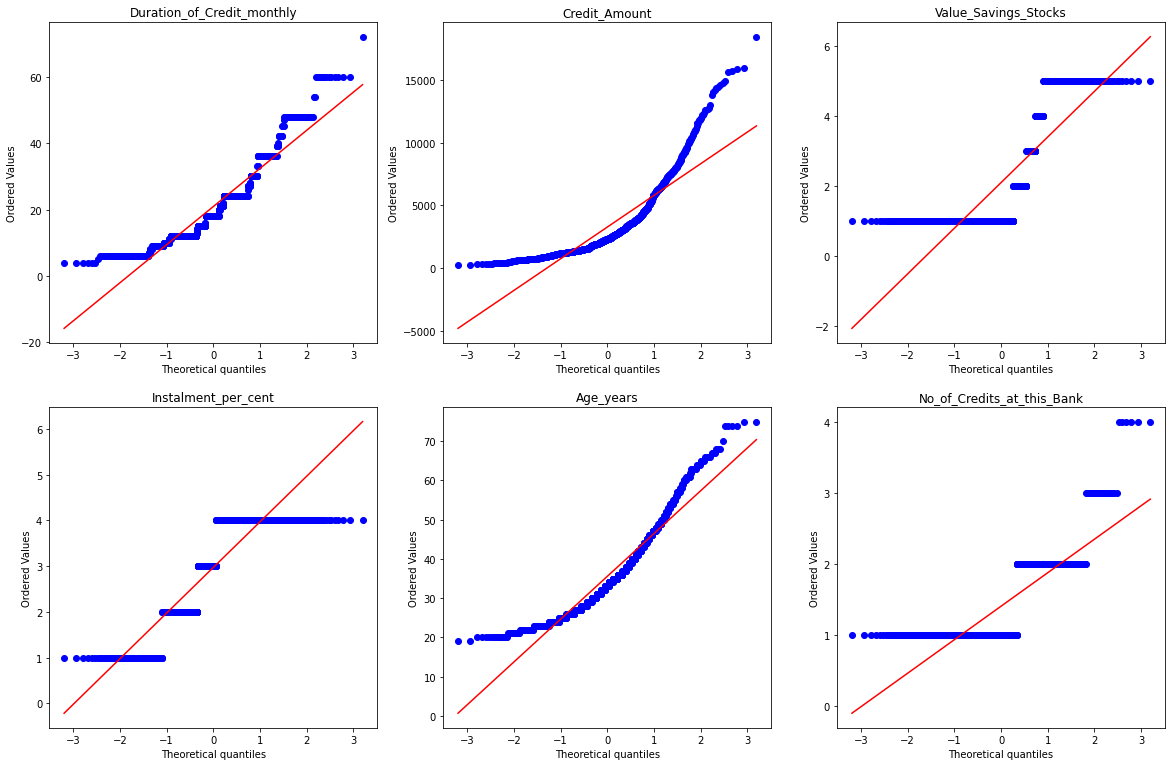

In [ ]:

# numeric column 별 분포 확인
plt.figure(figsize=(20,10))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2, wspace=0.2)
for column_name in list_numeric_columns:
    plt.subplot(2,3,x)
    x = x+1
    stats.probplot(df[column_name], dist=stats.norm, plot=plt)
    plt.title(column_name)
plt.show()

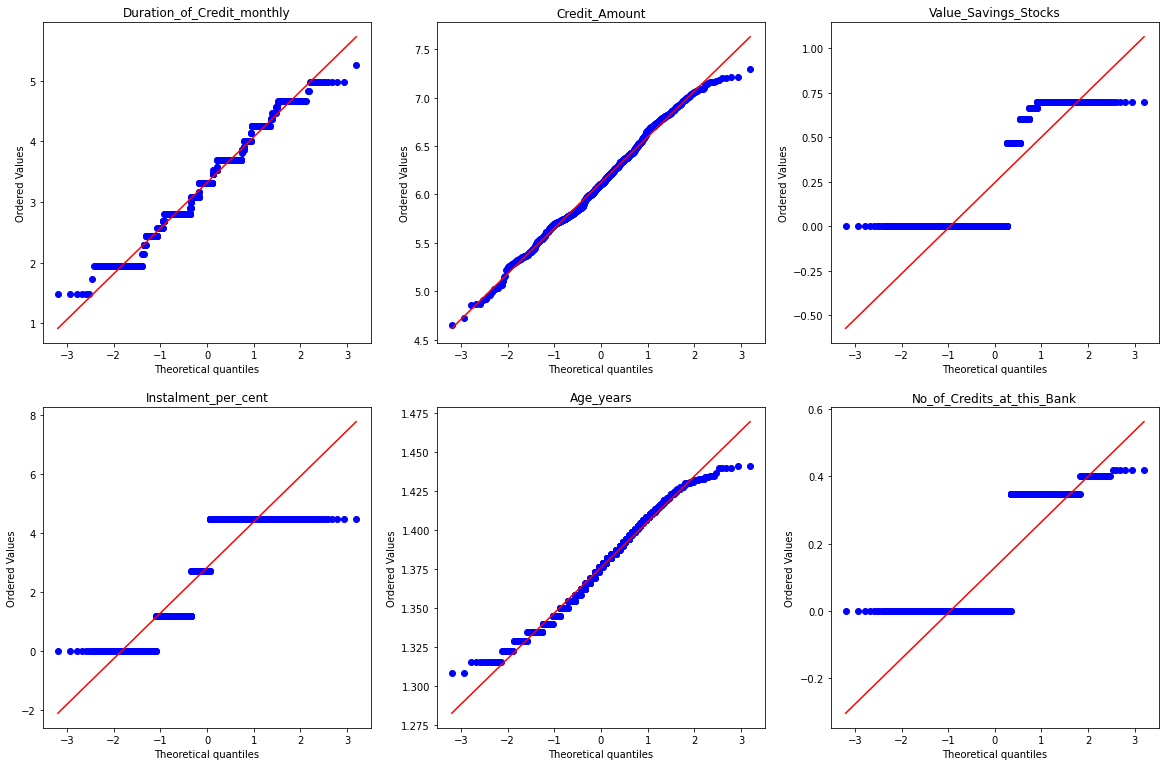

In [ ]:

# numeric column 별 분포 확인
plt.figure(figsize=(20,10))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2, wspace=0.2)
for column_name in list_numeric_columns:
    plt.subplot(2,3,x)
    x = x+1
    stats.probplot(stats.boxcox(df[column_name])[0], dist=stats.norm, plot=plt)
    plt.title(column_name)
plt.show()

정규성 만족하지 못함
*   정규성을 만족하지 못하므로, 등분산성 검정이 필요가 없음 (등분산성은 정규성을 전제)
*   일원분산분석을 통한 numeric data 검정 불가

##### 크루스칼 왈리스 검정 Kruskall-Wallis test (비모수 검정)
*   비모수 검정이기 때문에 정규성/등분산성을 만족하지 않아도됨
*   단, 비모수 검정이기 때문에 검정 결과 신뢰도가 모수 검정보다 떨어짐

In [ ]:
# kruskall 검정
list_meaningful_column_by_kruskall = []

for column_name in list_numeric_columns:
  list_by_value = []
  for value in df[target_column].dropna().unique():
      df_tmp = df[df[target_column] == value][column_name].dropna()
      list_by_value.append(np.array(df_tmp))
  statistic, pvalue = kruskal(*list_by_value)
  if pvalue <= 0.05:
    list_meaningful_column_by_kruskall.append(column_name)
  print(column_name, ", ",statistic,", ", pvalue)
print("all categorical columns : ", len(list_numeric_columns))
print("selected columns by kruskal : ", len(list_meaningful_column_by_kruskall), list_meaningful_column_by_kruskall)

Duration_of_Credit_monthly ,  42.263859684710084 ,  7.975280722435737e-11
Credit_Amount ,  7.575879507631307 ,  0.005915450904320812
Value_Savings_Stocks ,  30.663570435469385 ,  3.0687280146351794e-08
Instalment_per_cent ,  5.424750145998911 ,  0.01985327596986272
Age_years ,  12.810120621447924 ,  0.00034474934315396557
No_of_Credits_at_this_Bank ,  2.236544135434218 ,  0.13478191734200565
all categorical columns :  6
selected columns by kruskal :  5 ['Duration_of_Credit_monthly', 'Credit_Amount', 'Value_Savings_Stocks', 'Instalment_per_cent', 'Age_years']


##### Insight
1.   Creditability(종속 변수)와 유의미한 관계를 갖지 않는 numerical data가 확인됨 (6개중 5개가 유의미한 교호작용을 보임)
2.   feature selection 및 model optimization을 위해 1번에서 얻은 결과를 활용
3.   numercial data 간의 상관관계 중, 높은 상관 관계를 갖는 경우는 없다.
4.   numerical data 들은 skew 값보다 kurtosis 값이 큰 경향을 보이는 것들이 존재한다. 이는 preprocessing으로 데이터 분포를 정규화 할 수 있다.



### 2-4 EDA with pandas_profiling

In [ ]:
df.profile_report().to_file(path_lecture + "data/data_eda_with_pandasprofiling.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 3. Data Processing 2

### 3-1 Missing Values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Creditability                      1000 non-null   object
 1   Account_Balance                    1000 non-null   object
 2   Duration_of_Credit_monthly         1000 non-null   int64 
 3   Payment_Status_of_Previous_Credit  1000 non-null   object
 4   Purpose                            1000 non-null   object
 5   Credit_Amount                      1000 non-null   int64 
 6   Value_Savings_Stocks               1000 non-null   int64 
 7   Length_of_current_employment       1000 non-null   object
 8   Instalment_per_cent                1000 non-null   int64 
 9   Sex_Marital_Status                 1000 non-null   object
 10  Guarantors                         1000 non-null   object
 11  Duration_in_Current_address        1000 non-null   object
 12  Most_va

In [ ]:
df.isna().sum().sort_values(ascending=False)

Creditability                        0
Duration_in_Current_address          0
Telephone                            0
No_of_dependents                     0
Occupation                           0
No_of_Credits_at_this_Bank           0
Type_of_apartment                    0
Concurrent_Credits                   0
Age_years                            0
Most_valuable_available_asset        0
Guarantors                           0
Account_Balance                      0
Sex_Marital_Status                   0
Instalment_per_cent                  0
Length_of_current_employment         0
Value_Savings_Stocks                 0
Credit_Amount                        0
Purpose                              0
Payment_Status_of_Previous_Credit    0
Duration_of_Credit_monthly           0
Foreign_Worker                       0
dtype: int64

### 3-2 Encoding and Feature Selection

In [ ]:
Y = df[target_column]
X = df.drop([target_column], axis=1)

##### Label Encoding

In [ ]:
Y

0      1
1      1
2      1
3      1
4      1
      ..
995    0
996    0
997    0
998    0
999    0
Name: Creditability, Length: 1000, dtype: object

In [ ]:
le_encoder = LabelEncoder()
Y_encoded = le_encoder.fit_transform(Y)
Y_encoded

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

##### Feature Selection

In [ ]:
X_fs = df[list_meaningful_column_by_chi+list_meaningful_column_by_kruskall]
X_fs

,Account_Balance,Payment_Status_of_Previous_Credit,Purpose,Length_of_current_employment,Sex_Marital_Status,Guarantors,Most_valuable_available_asset,Concurrent_Credits,Type_of_apartment,Foreign_Worker,Duration_of_Credit_monthly,Credit_Amount,Value_Savings_Stocks,Instalment_per_cent,Age_years
0,1,4,2,2,2,1,2,3,1,1,18,1049,1,4,21
1,1,4,0,3,3,1,1,3,1,1,9,2799,1,2,36
2,2,2,9,4,2,1,1,3,1,1,12,841,2,2,23
3,1,4,0,3,3,1,1,3,1,2,12,2122,1,3,39
4,1,4,0,3,3,1,2,1,2,2,12,2171,1,4,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,2,3,3,3,1,1,3,1,1,24,1987,1,2,21
996,1,2,0,5,3,2,1,3,2,1,24,2303,1,4,45
997,4,4,0,5,3,1,4,3,3,1,21,12680,5,4,30
998,2,2,3,1,3,1,4,3,2,1,12,6468,5,2,52


In [ ]:
print(len(X.columns))
print(len(X_fs.columns))

20
15


##### Feature Transformation
*   Standardization과 Normalization은 다른 것.
*   Normalization은 [0,1]로 값을 scaling 하는 것 (예 sklearn의 MinMaxScaler())
*   Standardization은 정규분포의 표준화를 활용하여 scaling하는 것 (예 sklearn의 StandardScaler())



In [ ]:
X_fs.head(2)

,Account_Balance,Payment_Status_of_Previous_Credit,Purpose,Length_of_current_employment,Sex_Marital_Status,Guarantors,Most_valuable_available_asset,Concurrent_Credits,Type_of_apartment,Foreign_Worker,Duration_of_Credit_monthly,Credit_Amount,Value_Savings_Stocks,Instalment_per_cent,Age_years
0,1,4,2,2,2,1,2,3,1,1,18,1049,1,4,21
1,1,4,0,3,3,1,1,3,1,1,9,2799,1,2,36


In [ ]:
scaler = StandardScaler()
X_fs.loc[:, list_meaningful_column_by_kruskall] = scaler.fit_transform(X_fs[list_meaningful_column_by_kruskall])
X_fs.head(2)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Account_Balance,Payment_Status_of_Previous_Credit,Purpose,Length_of_current_employment,Sex_Marital_Status,Guarantors,Most_valuable_available_asset,Concurrent_Credits,Type_of_apartment,Foreign_Worker,Duration_of_Credit_monthly,Credit_Amount,Value_Savings_Stocks,Instalment_per_cent,Age_years
0,1,4,2,2,2,1,2,3,1,1,-0.240857,-0.787657,-0.699707,0.918477,-1.281573
1,1,4,0,3,3,1,1,3,1,1,-0.987573,-0.167384,-0.699707,-0.870183,0.040363


In [ ]:
X.loc[:, list_numeric_columns] = scaler.fit_transform(X[list_numeric_columns])
X.head(2)

,Account_Balance,Duration_of_Credit_monthly,Payment_Status_of_Previous_Credit,Purpose,Credit_Amount,Value_Savings_Stocks,Length_of_current_employment,Instalment_per_cent,Sex_Marital_Status,Guarantors,Duration_in_Current_address,Most_valuable_available_asset,Age_years,Concurrent_Credits,Type_of_apartment,No_of_Credits_at_this_Bank,Occupation,No_of_dependents,Telephone,Foreign_Worker
0,1,-0.240857,4,2,-0.787657,-0.699707,2,0.918477,2,1,4,2,-1.281573,3,1,-0.704926,3,1,1,1
1,1,-0.987573,4,0,-0.167384,-0.699707,3,-0.870183,3,1,2,1,0.040363,3,1,1.027079,3,2,1,1


In [ ]:
# MinMaxScaler Test
minmax_scaler = MinMaxScaler()
print(minmax_scaler.fit_transform(X_fs[list_meaningful_column_by_kruskall])[:2,:])

[[0.20588235 0.0439639  0.         1.         0.03571429]
 [0.07352941 0.14025531 0.         0.33333333 0.30357143]]


##### One-hot Encoding for categorical column data

In [ ]:
X_base = pd.get_dummies(X)
X_fs_final = pd.get_dummies(X_fs)

In [ ]:
X_fs_final.columns

Index(['Duration_of_Credit_monthly', 'Credit_Amount', 'Value_Savings_Stocks',
       'Instalment_per_cent', 'Age_years', 'Account_Balance_1',
       'Account_Balance_2', 'Account_Balance_3', 'Account_Balance_4',
       'Payment_Status_of_Previous_Credit_0',
       'Payment_Status_of_Previous_Credit_1',
       'Payment_Status_of_Previous_Credit_2',
       'Payment_Status_of_Previous_Credit_3',
       'Payment_Status_of_Previous_Credit_4', 'Purpose_0', 'Purpose_1',
       'Purpose_2', 'Purpose_3', 'Purpose_4', 'Purpose_5', 'Purpose_6',
       'Purpose_8', 'Purpose_9', 'Purpose_10',
       'Length_of_current_employment_1', 'Length_of_current_employment_2',
       'Length_of_current_employment_3', 'Length_of_current_employment_4',
       'Length_of_current_employment_5', 'Sex_Marital_Status_1',
       'Sex_Marital_Status_2', 'Sex_Marital_Status_3', 'Sex_Marital_Status_4',
       'Guarantors_1', 'Guarantors_2', 'Guarantors_3',
       'Most_valuable_available_asset_1', 'Most_valuable_availab

In [ ]:
X_fs_final.head(2)

,Duration_of_Credit_monthly,Credit_Amount,Value_Savings_Stocks,Instalment_per_cent,Age_years,Account_Balance_1,Account_Balance_2,Account_Balance_3,Account_Balance_4,Payment_Status_of_Previous_Credit_0,...,Most_valuable_available_asset_3,Most_valuable_available_asset_4,Concurrent_Credits_1,Concurrent_Credits_2,Concurrent_Credits_3,Type_of_apartment_1,Type_of_apartment_2,Type_of_apartment_3,Foreign_Worker_1,Foreign_Worker_2
0,-0.240857,-0.787657,-0.699707,0.918477,-1.281573,1,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0
1,-0.987573,-0.167384,-0.699707,-0.870183,0.040363,1,0,0,0,0,...,0,0,0,0,1,1,0,0,1,0


In [ ]:
X_base.head(2)

,Duration_of_Credit_monthly,Credit_Amount,Value_Savings_Stocks,Instalment_per_cent,Age_years,No_of_Credits_at_this_Bank,Account_Balance_1,Account_Balance_2,Account_Balance_3,Account_Balance_4,...,Occupation_1,Occupation_2,Occupation_3,Occupation_4,No_of_dependents_1,No_of_dependents_2,Telephone_1,Telephone_2,Foreign_Worker_1,Foreign_Worker_2
0,-0.240857,-0.787657,-0.699707,0.918477,-1.281573,-0.704926,1,0,0,0,...,0,0,1,0,1,0,1,0,1,0
1,-0.987573,-0.167384,-0.699707,-0.870183,0.040363,1.027079,1,0,0,0,...,0,0,1,0,0,1,1,0,1,0


### 3-3 Summary
##### 총 2개 유형의 feature를 생성 -> model optimization 실험
1.   No Feature Selection (X_base, Y_encoded)
2.   Feature Selection (X_fs_final, Y_encoded)
  

## 4. Model Analysis
0.   base model without Feature Selection
1.   base model with Feature Selection
2.   Model Optimization with random search  

In [ ]:
cv = 3
n_jobs = -1

### 4-1. Base Model Learning

In [ ]:
list_cast_to_int  = list(X_base.select_dtypes(include=['object']).columns)
X_base.loc[:, list_cast_to_int] = X_base[list_cast_to_int].apply(lambda x : x.astype("int64"))
X_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 61 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Duration_of_Credit_monthly           1000 non-null   float64
 1   Credit_Amount                        1000 non-null   float64
 2   Value_Savings_Stocks                 1000 non-null   float64
 3   Instalment_per_cent                  1000 non-null   float64
 4   Age_years                            1000 non-null   float64
 5   No_of_Credits_at_this_Bank           1000 non-null   float64
 6   Account_Balance_1                    1000 non-null   uint8  
 7   Account_Balance_2                    1000 non-null   uint8  
 8   Account_Balance_3                    1000 non-null   uint8  
 9   Account_Balance_4                    1000 non-null   uint8  
 10  Payment_Status_of_Previous_Credit_0  1000 non-null   uint8  
 11  Payment_Status_of_Previous_Cred

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_base, Y_encoded, test_size = 0.3, random_state = random_state, stratify=Y_encoded)

In [ ]:
rf_clf = RandomForestClassifier(max_depth = 4, n_estimators=5)
rf_clf.fit(X_train, y_train)
y_prd = rf_clf.predict(X_test)
y_prd_proba = rf_clf.predict_proba(X_test)[:,-1]
prf_score = precision_recall_fscore_support(y_test, y_prd, average='binary')
score = roc_auc_score(y_test, y_prd_proba)
print("precision, recall, f1score : ", prf_score)
print("roc_auc_score : ", score)

precision, recall, f1score :  (0.7226277372262774, 0.9428571428571428, 0.8181818181818182, None)
roc_auc_score :  0.7185978835978837


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_fs_final, Y_encoded, test_size = 0.3, random_state = random_state, stratify=Y_encoded)

In [ ]:
rf_clf = RandomForestClassifier(max_depth = 4, n_estimators=5)
rf_clf.fit(X_train, y_train)
y_prd = rf_clf.predict(X_test)
y_prd_proba = rf_clf.predict_proba(X_test)[:,-1]
prf_score = precision_recall_fscore_support(y_test, y_prd, average='binary')
score = roc_auc_score(y_test, y_prd_proba)
print("precision, recall, f1score : ", prf_score)
print("roc_auc_score : ", score)

precision, recall, f1score :  (0.7414448669201521, 0.9285714285714286, 0.8245243128964059, None)
roc_auc_score :  0.7012698412698413


### 4-2. Optimization 2 : RandomForest and RandomizedSearchCV

##### RandomizedSearchCV란?
*   Estimator 결정할 때 최적의 Hyper-Parameter를 찾기 위한 방법 중 하나. (일반적으로 3가지 방법이 있으며, GridSearch/RandomSearch/Bayesian Search)
*   Random하게 Hyper-Parameter를 조합하여 반복하며 최적의 값을 찾아주는 방법
*   Cross Validation도 같이 진행되기 떄문에 신뢰할 수 있는 결과물을 얻을 수 있다.
*   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
*   https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

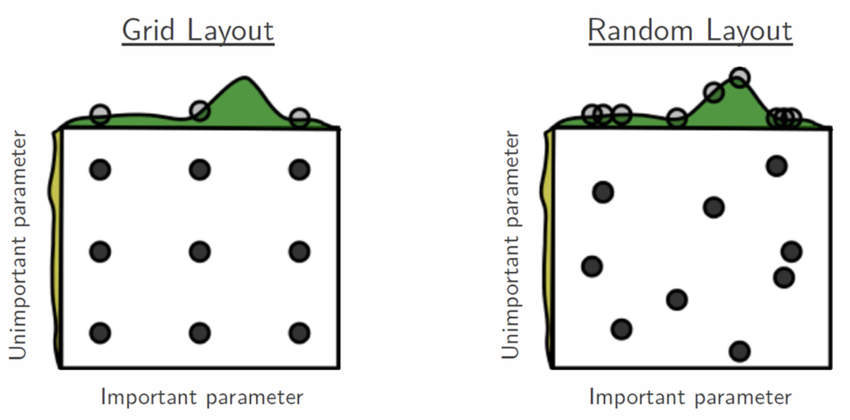

In [ ]:
Image(path_lecture + "img/Grid-and-Random-Layout.png")

In [ ]:
len(X_test.columns)

15

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_base, Y_encoded, test_size = 0.3, random_state = random_state, stratify=Y_encoded)

In [ ]:
hyper_params_rf_randomized = {"max_features" : sp_randInt(7,10),
                              "max_depth" : sp_randInt(6,20),
                              "n_estimators" : sp_randInt(15,60),
}

rf_clf = RandomForestClassifier(max_depth = 4, n_estimators=5)
random_cv_opt = RandomizedSearchCV(estimator=rf_clf, param_distributions=hyper_params_rf_randomized, n_iter=30, cv = cv, n_jobs = n_jobs, random_state=random_state, scoring='roc_auc', verbose=1)
random_cv_opt.fit(X_train, y_train)
print('best model hyper-parameter : ', random_cv_opt.best_params_)
y_prd = random_cv_opt.predict(X_test)
prf_score = precision_recall_fscore_support(y_test, y_prd, average='binary')
print("precision, recall, f1score : ", prf_score)
y_prd_proba = random_cv_opt.predict_proba(X_test)[:,-1]
score = roc_auc_score(y_test, y_prd_proba)
print("roc_auc_score : ", score)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
best model hyper-parameter :  {'max_depth': 15, 'max_features': 7, 'n_estimators': 59}
precision, recall, f1score :  (0.7673469387755102, 0.8952380952380953, 0.8263736263736263, None)
roc_auc_score :  0.7398412698412699


In [ ]:
#Gridsearch Test
hyper_params_rf = {"max_features":[6,9],
                    'max_depth': [8, 15, 20],
                    'n_estimators': [15, 20, 50, 60]
                   }
rf_clf = RandomForestClassifier(max_depth = 4, n_estimators=5)
grid_cv_opt = GridSearchCV(rf_clf, param_grid = hyper_params_rf, cv = cv, n_jobs = n_jobs, scoring='roc_auc', verbose=1)
grid_cv_opt.fit(X_train, y_train)
print('best model hyper-parameter : ', grid_cv_opt.best_params_)
y_prd = grid_cv_opt.predict(X_test)
prf_score = precision_recall_fscore_support(y_test, y_prd, average='binary')
print("precision, recall, f1score : ", prf_score)
y_prd_proba = grid_cv_opt.predict_proba(X_test)[:,-1]
score = roc_auc_score(y_test, y_prd_proba)
print("roc_auc_score : ", score)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
best model hyper-parameter :  {'max_depth': 8, 'max_features': 9, 'n_estimators': 60}
precision, recall, f1score :  (0.7717842323651453, 0.8857142857142857, 0.8248337028824835, None)
roc_auc_score :  0.7557671957671958


##### Note
*   RandomSearch와 GridSearch는 각 기 장점/단점이 존재한다.
*   여러 연구 논문에서는 확률적으로 RandomSearch가 더 좋은 성능의 모델 결과물을 내놓을 **확률이 높다**고 주장한다.
*   주의점 : 항상 RandomSearch가 높게 나오는 것은 아니다. 주어진 parameter, random_state, n_iter에 따라 항상 변화된다.



### 4-2. Model Analysis

##### Feature Importance

In [ ]:
# reproduction
rf_clf = RandomForestClassifier(**random_cv_opt.best_params_)
final_model = rf_clf.fit(X_train, y_train)

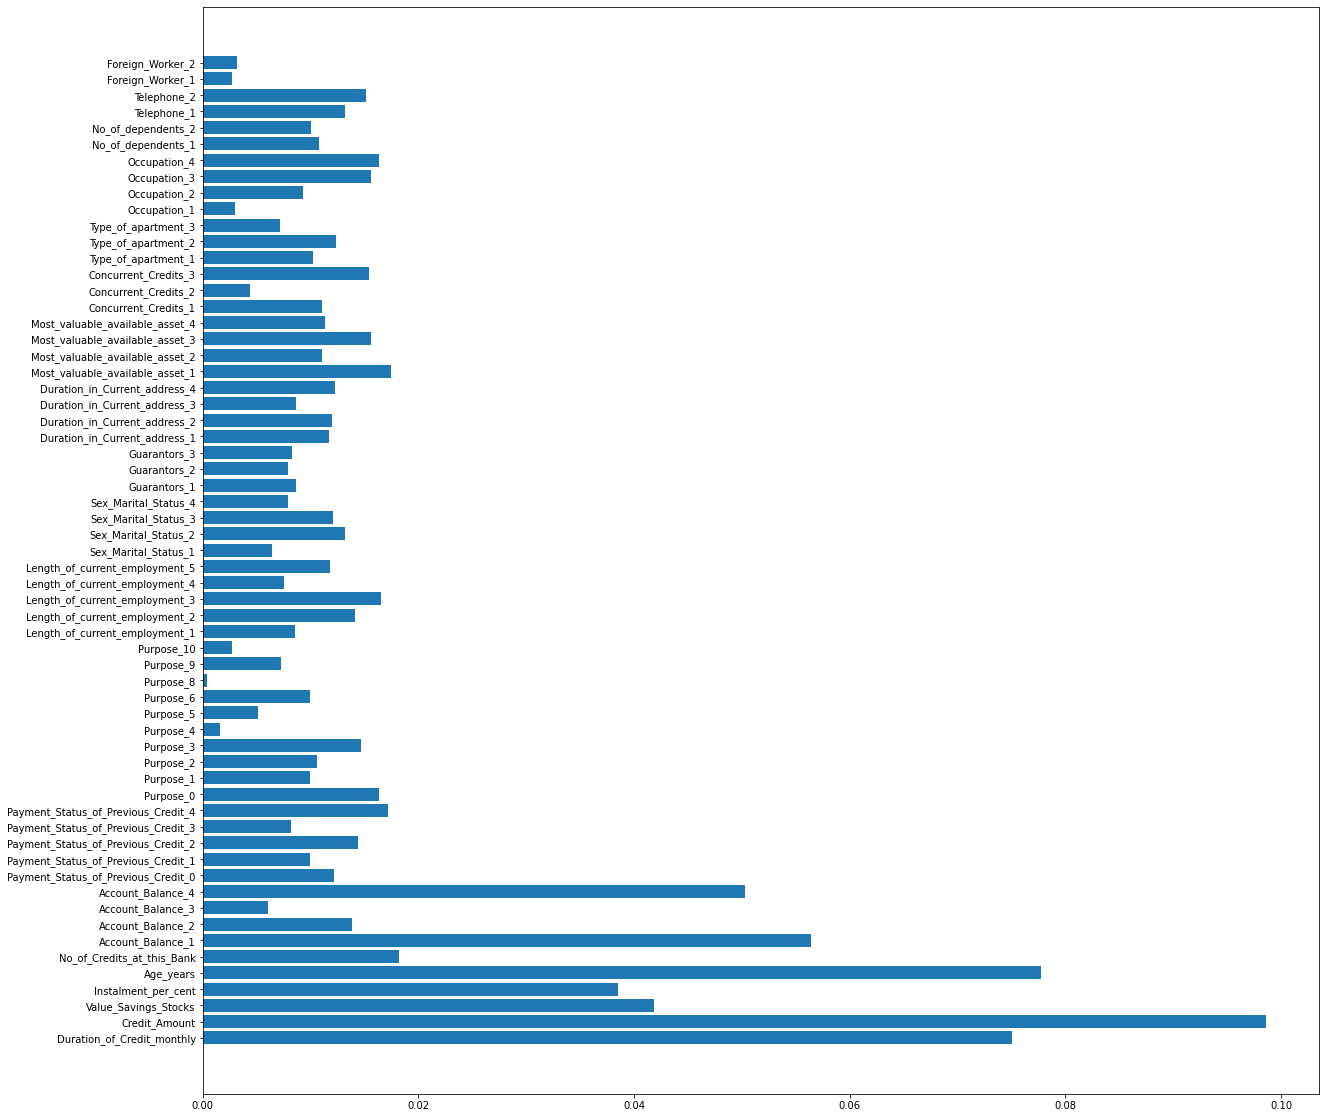

In [ ]:
plt.figure(figsize=(20,20))
ax = plt.barh(list(X_base.columns),rf_clf.feature_importances_)

##### Shapley Value
*   게임 이론에 근거해서 만들어진 값 (https://ko.wikipedia.org/wiki/게임이론)
*   하나의 특성에 대한 중요도를 알기위해 여러 특성들의 조합을 구성하고 해당 특성의 유무에 따른 변화를 분석해서 얻어낸 값
*.  Explainable AI
*   https://en.wikipedia.org/wiki/Shapley_value



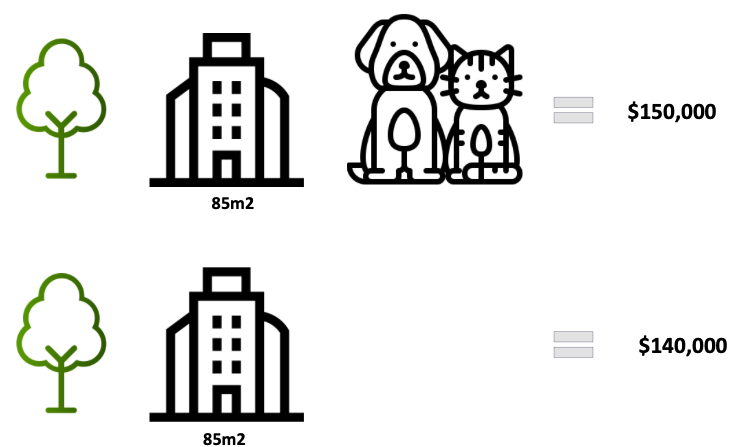

In [ ]:
Image(path_lecture + "img/shapley_value.png")

In [ ]:
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

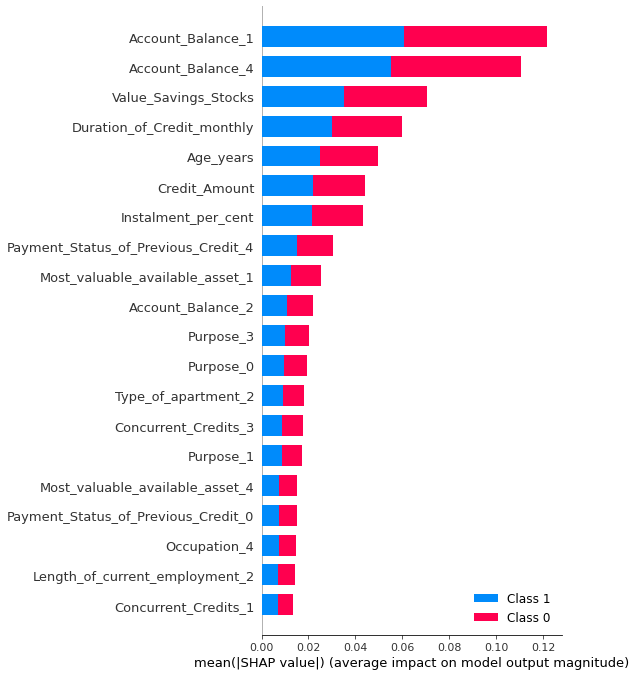

In [ ]:
shap.summary_plot(shap_values, X_test)